In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import cv2
from sklearn.mixture import GaussianMixture as gmm
import scipy.stats as st

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Class to compute uncertainty

In [2]:
class logit_uncertainty:

    def __init__(self, model, train_data, train_labels, q1 = 80, q2 = 60, u1 = 0.5, u2 = 0.2, components = 0):
        '''
        This function prepares a logit uncertainty instance 
        that can be used to compute uncertainty multiple times
        default q1, q2, u1, u2 works with MNIST and CIFAR10, can be changed
        
        model: the trained model, need to support model.predict(), 
               addtionally, the model.predict() should return logit values (not probabilities)
        train_data: training data, 
        train_labels: one hot encoded training labels
        q1: q1 in the paper
        q2: q2 in the paper
        u1: u1 in the paper
        u2: u2 in the paper
        components: a list of number of components for GMMs for each class
        '''
        # number of classes
        self.classes = train_labels.shape[-1]
        
        # get true predictions
        logits = model.predict(train_data)
        predictions = np.argmax(logits, axis = 1)
        true_pred = []
        for current_label in range(self.classes):
            true_pred.append(logits[np.logical_and(predictions == current_label, 
                                                   np.argmax(train_labels, axis = 1) == current_label)])
            
        # if nunmber of components are not given, loop through the classes to find number of components
        # otherwise use the number of components given
        n_components = np.arange(1, 20)
        if components == 0:
            components = []
            for current_label in range(self.classes):
                classi = true_pred[current_label]
                models = [gmm(n, covariance_type='full', random_state=0).fit(classi)
                  for n in n_components]
                plt.plot(n_components, [m.bic(classi) for m in models], label='BIC')
                plt.grid()
                plt.legend(loc='best')
                plt.xlabel('n_components')
                plt.show()
                num = input ('Please enter number of components: ') 
                components.append(int(num))
        
        # compute the GMMs
        gmms = []
        for i in range(self.classes):
            gmms.append(gmm(components[i], covariance_type='full', random_state=0).fit(true_pred[i]))
        
        # find max of log pdf of GMMs
        max_log = []
        for i in range(self.classes):
            temp = gmms[i]
            max_log.append(np.max(temp.score_samples(temp.means_)))
        
        # the scores in the paper for the training data
        scores = []
        for i in range(self.classes):
            scores.append(np.log(np.exp(max_log[i]) / np.exp(gmms[i].score_samples(gmms[i].sample(10000)[0]))))
            
        self.gmms = gmms
        self.max_log = max_log
        self.scores = scores

        self.set_up(q1, q2, u1, u2)
        
    def set_up(self, q1, q2, u1, u2):
        '''
        This function help you make your own assumptions
        q1, q2, u1, u2 have default values, but can be adjusted to your need and for experiments
        
        q1: q1 in paper
        q2: q2 in paper
        u1: u1 in paper
        u2: u2 in paper
        '''
        # sq1 and sq2 in paper
        sq1 = []
        sq2 = []
        for i in range(self.classes):
            sq1.append(np.percentile(self.scores[i], q1))
            sq2.append(np.percentile(self.scores[i], q2))

        # x0 and m used in logistic funtion
        self.x0 = (np.array(sq2) * np.log(1/u1 - 1) - np.array(sq1) * np.log(1/u2 - 1)) / (np.log((1/u1-1) / (1/u2 - 1)))
        self.m = -np.log(1/u2 - 1) / (sq2 - self.x0)    

        
        
    def compute_uncertainty(self, model, test_data):
        '''
        The funtion used to compute logit uncertainty
        
        mode: the same model used in set up
        test_data: the data that you want to compute uncertainty
        
        return: list of uncertainty for each of the test_data
        '''
        logits = model.predict(test_data)
        label = np.argmax(logits, axis = 1)
        u = []
        for i in range(len(logits)):
            pred = label[i]
            score = (np.log(np.exp(self.max_log[pred]) 
                            / np.exp(self.gmms[pred].score_samples(logits[i].reshape(1, -1)))))[0]
            u.append(1 / (1 + np.exp(-self.m[pred]*(score - self.x0[pred]))))
        return u

# Usage example using MNIST

### Create and train model on MNIST

In [3]:
# CNN model for MNIST
def create_model():
    my_model = tf.keras.models.Sequential([
            keras.layers.Conv2D(20, (5, 5), activation='relu', input_shape=(28, 28, 1), 
                                kernel_initializer = tf.keras.initializers.he_normal(seed = 100), 
                                bias_initializer = tf.keras.initializers.he_normal(seed = 100)),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Conv2D(50, (5, 5), activation='relu', 
                                kernel_initializer = tf.keras.initializers.he_normal(seed = 100), 
                                bias_initializer = tf.keras.initializers.he_normal(seed = 100)),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(500, activation='relu',  
                                kernel_initializer = tf.keras.initializers.he_normal(seed = 100), 
                                bias_initializer = tf.keras.initializers.he_normal(seed = 100)),
            keras.layers.Dense(10,
                                kernel_initializer = tf.keras.initializers.he_normal(seed = 100), 
                                bias_initializer = tf.keras.initializers.he_normal(seed = 100))
    ])
    return my_model

In [4]:
# get the mnist dataset
(train_images_origin, train_labels_origin), (images, labels) = tf.keras.datasets.mnist.load_data()


# note we have to mark the labels using one-hot-encoding in order to compute loss
train_labels = train_labels_origin[:55000]
train_labels = keras.utils.to_categorical(train_labels)
validation_labels = train_labels_origin[55000:]
validation_labels = keras.utils.to_categorical(validation_labels)
test_labels = labels
test_labels = keras.utils.to_categorical(test_labels)

# get the images, divide all by 255
train_images = np.array(train_images_origin[:55000]).reshape((55000, 28, 28, 1)) / 255.0
validation_images = np.array(train_images_origin[55000:]).reshape((5000, 28, 28, 1)) / 255.0
test_images = np.array(images).reshape((10000, 28, 28, 1)) / 255.0

In [5]:
# train our model on MNIST
model = create_model()

model.compile(
    optimizer = 'adam',
    loss = tf.losses.softmax_cross_entropy,
    metrics = ['accuracy']
)

model.fit(train_images, train_labels, epochs = 30, batch_size = 1000, 
             verbose = 2,
             validation_data = (validation_images, validation_labels), 
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 - 2s - loss: 0.7962 - acc: 0.7951 - val_loss: 0.1391 - val_acc: 0.9600
Epoch 2/30
55000/55000 - 1s - loss: 0.1316 - acc: 0.9623 - val_loss: 0.0706 - val_acc: 0.9802
Epoch 3/30
55000/55000 - 1s - loss: 0.0756 - acc: 0.9775 - val_loss: 0.0557 - val_acc: 0.9832
Epoch 4/30
55000/55000 - 1s - loss: 0.0554 - acc: 0.9835 - val_loss: 0.0467 - val_acc: 0.9870
Epoch 5/30
55000/55000 - 1s - loss: 0.0449 - acc: 0.9866 - val_loss: 0.0444 - val_acc: 0.9882
Epoch 6/30
55000/55000 - 1s - loss: 0.0366 - acc: 0.9892 - val_loss: 0.0385 - val_acc: 0.9884
Epoch 7/30
55000/55000 - 1s - loss: 0.0314 - acc: 0.9906 - val_loss: 0.0374 - val_acc: 0.9892
Epoch 8/30
55000/55000 - 1s - loss: 0.0269 - acc: 0.9918 - val_loss: 0.0403 - val_acc: 0.9874
Epoch 9/30
55000/55000 - 1s - loss: 0.0239 - acc: 0.9925 - val_loss: 0.0326 - val_acc: 0.9908
Epoch 10/30

### Using the logit_uncertainty class

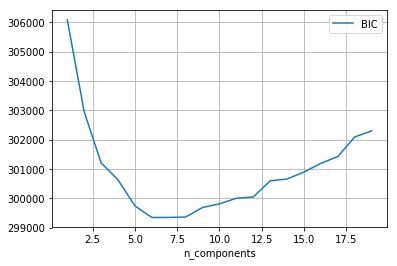

Please enter number of components:  6


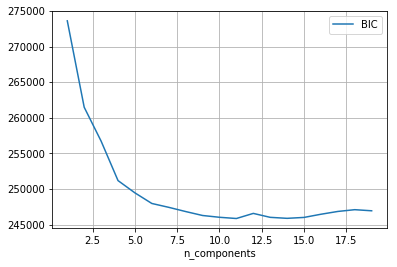

Please enter number of components:  7


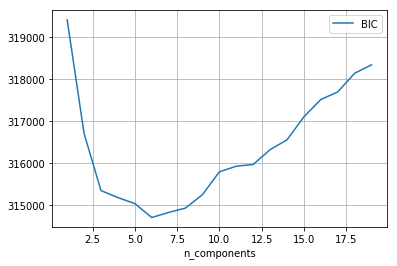

Please enter number of components:  6


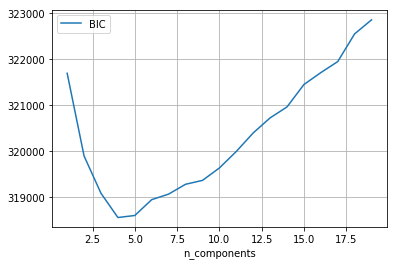

Please enter number of components:  4


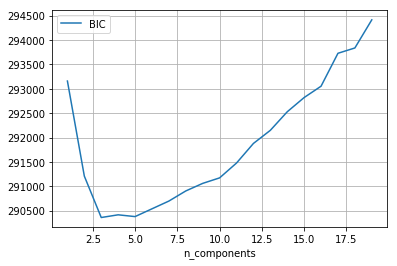

Please enter number of components:  3


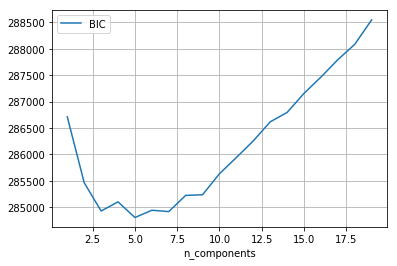

Please enter number of components:  3


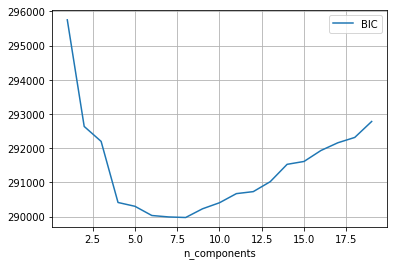

Please enter number of components:  6


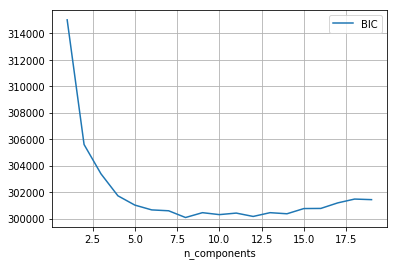

Please enter number of components:  6


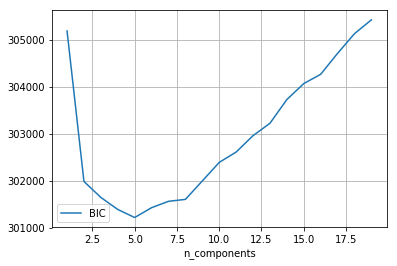

Please enter number of components:  5


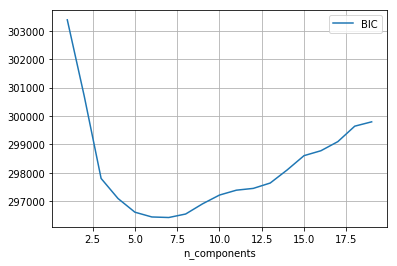

Please enter number of components:  6


In [6]:
# create an instance
my_uncertainty = logit_uncertainty(model, train_images, train_labels)
# follow the prompt and use elbow rule to select number of components for each class

# if you already know the number of components (using same model weights from previous runs)
# use the following line, change the components argument
# my_uncertainty = logit_uncertainty(model, train_images, train_labels, components = [7,6,6,5,5,5,5,6,5,5])

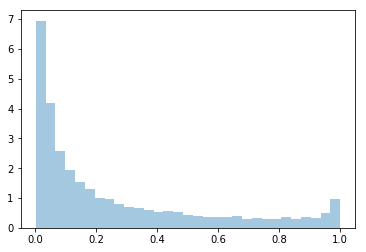

In [7]:
# Compute uncertainty on all of the test images
u_all = my_uncertainty.compute_uncertainty(model, test_images)

# plot the distribution plot of uncertainty values
sns.distplot(u_all, kde = False, norm_hist = True)

In [8]:
# Find incorrectly predicted images in test set
logits = model.predict(test_images)
pred = np.argmax(logits, axis = 1)
wrong_images = test_images[pred != np.argmax(test_labels, axis = 1)]

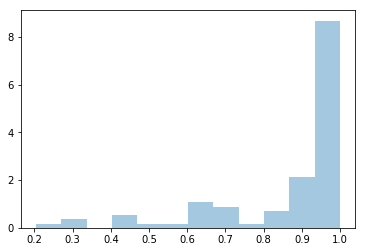

In [9]:
# compute uncertainty values on the incorrectly predicted images
u_wrong = my_uncertainty.compute_uncertainty(model, wrong_images)

# plot the distribution plot of uncertainty values for wrong predictions
sns.distplot(u_wrong, kde = False, norm_hist = True)

### Testing on out of sample exmaples
Our model is trained on MNIST, here we use the model trained on the MNIST to predict Fashion-MNIST images, and compute uncertaity on such predictions

In [10]:
# download the fashion mnsit dataset
fashion_mnist = keras.datasets.fashion_mnist
(f_train_images, f_train_labels), (f_test_images, f_test_labels) = fashion_mnist.load_data()
f_test_images = f_train_images.reshape((60000, 28, 28, 1)) / 255.0

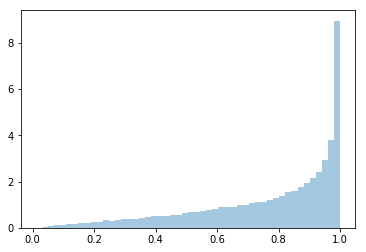

In [11]:
# compute uncertainty on predictions on Fashion-MNIST for model trained on MNIST
u_fashion = my_uncertainty.compute_uncertainty(model, f_test_images)

sns.distplot(u_fashion, kde = False, norm_hist = True)

### Testing on MNIST using differnt assumptions (different q1, q2, u1, u2 values)

In [12]:
# set up our instance using the new assumption
my_uncertainty.set_up(80, 50, 0.8, 0.2)

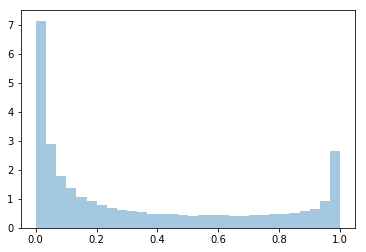

In [13]:
# compute and plot uncertainty values for all of the training images with the new assumption
u_all_new = my_uncertainty.compute_uncertainty(model, train_images)

sns.distplot(u_all_new, kde = False, norm_hist = True)

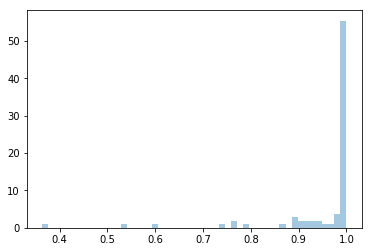

In [14]:
# compute and plot uncertainty values for wrongly predicted images with the new assumption
u_wrong_new = my_uncertainty.compute_uncertainty(model, wrong_images)

sns.distplot(u_wrong_new, kde = False, norm_hist = True)

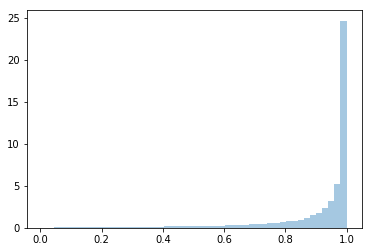

In [15]:
# compute and plot uncertainty values for Fashion-MNIST images with the new assumption
u_fashion_new = my_uncertainty.compute_uncertainty(model, f_test_images)

sns.distplot(u_fashion_new, kde = False, norm_hist = True)